In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [3]:
!pip install Darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 784.8/784.8 kB 10.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.0 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.0/275.0 kB 20.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 12.7 MB/s eta 0:00:00
  Created wheel 

In [4]:
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [5]:
base = "/kaggle/input/store-sales-time-series-forecasting/"

In [6]:
oil = pd.read_csv(base+"oil.csv",parse_dates=['date'])
holidays_events = pd.read_csv(base+"holidays_events.csv",parse_dates=['date'])
sample_submission = pd.read_csv(base+"sample_submission.csv")
stores = pd.read_csv(base+"stores.csv")
test = pd.read_csv(base+"test.csv",parse_dates=['date'])
train = pd.read_csv(base+"train.csv",parse_dates=['date'])
transactions = pd.read_csv(base+"transactions.csv",parse_dates=['date'])

In [7]:
print(f'Number of data_oil samples: {oil.shape}')
print(f'Number of train_data samples: {train.shape}')
print(f'Number of test_data samples: {test.shape}')
print(f'Number of samp_subm samples: {sample_submission.shape}')
print(f'Number of data_holi samples: {holidays_events.shape}')
print(f'Number of data_store samples: {stores.shape}')
print(f'Number of data_trans samples: {transactions.shape}')

Number of data_oil samples: (1218, 2)
Number of train_data samples: (3000888, 6)
Number of test_data samples: (28512, 5)
Number of samp_subm samples: (28512, 2)
Number of data_holi samples: (350, 6)
Number of data_store samples: (54, 5)
Number of data_trans samples: (83488, 3)


In [8]:
display(train)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0
1,1,2013-01-01,1,BABY CARE,0.000,0
2,2,2013-01-01,1,BEAUTY,0.000,0
3,3,2013-01-01,1,BEVERAGES,0.000,0
4,4,2013-01-01,1,BOOKS,0.000,0
...,...,...,...,...,...,...
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8


In [9]:
display(test)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9


In [10]:
display(oil)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20
...,...,...
1213,2017-08-25,47.65
1214,2017-08-28,46.40
1215,2017-08-29,46.46
1216,2017-08-30,45.96


In [11]:
display(holidays_events)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


In [12]:
holidays_events[holidays_events["locale_name"].str.contains("Esmeraldas")]

,date,type,locale,locale_name,description,transferred
13,2012-08-05,Holiday,Local,Esmeraldas,Fundacion de Esmeraldas,False
66,2013-08-05,Holiday,Local,Esmeraldas,Fundacion de Esmeraldas,False
129,2014-08-05,Holiday,Local,Esmeraldas,Fundacion de Esmeraldas,False
184,2015-08-05,Holiday,Local,Esmeraldas,Fundacion de Esmeraldas,False
267,2016-08-05,Holiday,Local,Esmeraldas,Fundacion de Esmeraldas,False
323,2017-08-05,Holiday,Local,Esmeraldas,Fundacion de Esmeraldas,False


In [13]:
display(stores.head(52))

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [14]:
display(transactions)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922
...,...,...,...
83483,2017-08-15,50,2804
83484,2017-08-15,51,1573
83485,2017-08-15,52,2255
83486,2017-08-15,53,932


# ****Oil Preprocess****

In [15]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [16]:
oil.rename(columns={'dcoilwtico': 'oil_price'}, inplace=True)
oil["oil_price"][0]=93.14

/tmp/ipykernel_32/2322229302.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oil["oil_price"][0]=93.14


In [17]:
start_date = oil['date'].min()
end_date = oil['date'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Eksik tarihleri içeren bir DataFrame oluşturun
missing_dates = pd.DataFrame({'date': date_range})
missing_dates = missing_dates[~missing_dates['date'].isin(oil['date'])]

# NaN değerleri olan bir DataFrame oluşturun
missing_dates['oil_price'] = None  # Örneğin, 'oil_price' sütununu NaN olarak ayarlayın

# Eksik tarihleri doldurun
oil = pd.concat([oil, missing_dates], ignore_index=True)

In [18]:
oil['oil_price'].interpolate(method='linear', inplace=True)
oil["oil_price"]= oil["oil_price"].astype(float)

In [19]:
oil["oil_price"].isnull().sum()

0

In [20]:
oil['oil_price_ma3'] = oil["oil_price"].rolling(window=3, min_periods=1).mean()
oil['oil_price_ma7'] = oil["oil_price"].rolling(window=7, min_periods=1).mean()

In [21]:
scalerOil = MinMaxScaler()

# Belirli sütunları seçip ölçekleyelim
columns_to_scale = ['oil_price','oil_price_ma3','oil_price_ma7']
oil[columns_to_scale] = scalerOil.fit_transform(oil[columns_to_scale])

In [22]:
oil.head()

,date,oil_price,oil_price_ma3,oil_price_ma7
0,2013-01-01,0.792965,0.800364,0.806023
1,2013-01-02,0.792965,0.800364,0.806023
2,2013-01-03,0.790951,0.799676,0.805317
3,2013-01-04,0.792728,0.799595,0.805431
4,2013-01-07,0.793675,0.799838,0.805699


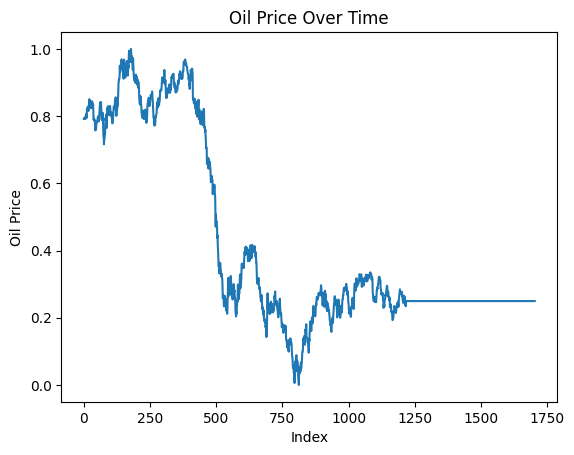

In [23]:
oil["oil_price"].plot(x=oil.date)

plt.xlabel("Index")
plt.ylabel("Oil Price")
plt.title("Oil Price Over Time")
plt.show()

In [24]:
start_date = oil['date'].min()
end_date = oil['date'].max()
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Eksik tarihleri içeren bir DataFrame oluşturun
missing_dates = pd.DataFrame({'date': date_range})
missing_dates = missing_dates[~missing_dates['date'].isin(oil['date'])]

# NaN değerleri olan bir DataFrame oluşturun
missing_dates['oil_price'] = None  # Örneğin, 'oil_price' sütununu NaN olarak ayarlayın

# Eksik tarihleri doldurun
oil = pd.concat([oil, missing_dates], ignore_index=True)

# **Time**

In [25]:
train.date.min(),test.date.max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-31 00:00:00'))

In [26]:
# Başlangıç ve bitiş tarihlerini belirleyin
start_date = train.date.min()
end_date = test.date.max()

# Tarih aralığını bir DataFrame'e dönüştürün
time = pd.DataFrame({
    "date": pd.date_range(start_date, end_date, freq='D')
})

# Tarih özelliklerini ekleyin
time["DayOfWeek"] = time["date"].dt.weekday
time["DayOfMonth"] = time["date"].dt.day
time["DayOfYear"] = time["date"].dt.dayofyear
time["WeekOfYear"] = time["date"].dt.isocalendar().week
time["Month"] = time["date"].dt.month
time["Year"] = time["date"].dt.year
time["IsWeekend"] = time["DayOfWeek"].isin([5, 6]).astype(int)
time["WorkDay"] = time["DayOfWeek"].isin([0, 1, 2, 3, 4]).astype(int)
time["Quarter"] = time["date"].dt.quarter

time["WagesDay"] = ((time["DayOfMonth"] == 15) | (time['date'].dt.day == time['date'].dt.days_in_month)).astype(int)
time["linear"] = pd.Series(range(1, len(time) + 1), index=time.index)

# Çıktıyı yazdırın
display(time)

,date,DayOfWeek,DayOfMonth,DayOfYear,WeekOfYear,Month,Year,IsWeekend,WorkDay,Quarter,WagesDay,linear
0,2013-01-01,1,1,1,1,1,2013,0,1,1,0,1
1,2013-01-02,2,2,2,1,1,2013,0,1,1,0,2
2,2013-01-03,3,3,3,1,1,2013,0,1,1,0,3
3,2013-01-04,4,4,4,1,1,2013,0,1,1,0,4
4,2013-01-05,5,5,5,1,1,2013,1,0,1,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1699,2017-08-27,6,27,239,34,8,2017,1,0,3,0,1700
1700,2017-08-28,0,28,240,35,8,2017,0,1,3,0,1701
1701,2017-08-29,1,29,241,35,8,2017,0,1,3,0,1702
1702,2017-08-30,2,30,242,35,8,2017,0,1,3,0,1703


# **Stores and Holiday_Events**

In [27]:
display(stores.head())
display(holidays_events.head())

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [28]:
holidays_events = holidays_events.apply(lambda x: x.str.lower() if x.name in ['type', 'locale', "locale_name",'description'] else x)
stores = stores.apply(lambda x: x.str.lower() if x.name in ['city', 'state'] else x)

In [29]:
holidays_events["type"].unique()

array(['holiday', 'transfer', 'additional', 'bridge', 'work day', 'event'],
      dtype=object)

In [30]:
time[time["date"]=="2016-11-04"]

,date,DayOfWeek,DayOfMonth,DayOfYear,WeekOfYear,Month,Year,IsWeekend,WorkDay,Quarter,WagesDay,linear
1403,2016-11-04,4,4,309,44,11,2016,0,1,4,0,1404


In [31]:
print(len(holidays_events[holidays_events["type"]=="holiday"]))
holidays_events[holidays_events["type"]=="holiday"]

221


,date,type,locale,locale_name,description,transferred
0,2012-03-02,holiday,local,manta,fundacion de manta,False
1,2012-04-01,holiday,regional,cotopaxi,provincializacion de cotopaxi,False
2,2012-04-12,holiday,local,cuenca,fundacion de cuenca,False
3,2012-04-14,holiday,local,libertad,cantonizacion de libertad,False
4,2012-04-21,holiday,local,riobamba,cantonizacion de riobamba,False
...,...,...,...,...,...,...
338,2017-11-12,holiday,local,ambato,independencia de ambato,False
340,2017-12-06,holiday,local,quito,fundacion de quito,True
341,2017-12-08,holiday,local,loja,fundacion de loja,False
344,2017-12-22,holiday,local,salinas,cantonizacion de salinas,False


In [32]:
holidays_events_fixed = pd.DataFrame()

In [33]:
# Yeni bir veri çerçevesi oluşturun ve orijinal veri çerçevesinin kopyasını alın
holi = holidays_events[holidays_events["type"] == "holiday"].copy()

# Kırpılacak kelimeleri içeren liste
keywords = ['futbol', 'black friday', "dia de la madre", "terremoto manabi", "cyber monday", 'fundacion', 'independencia', 'cantonizacion', 'provincializacion','dia de difuntos',"primer","navidad","carnaval",'batalla']

# "type" sütunu "event" olan satırları işleyin
mask = holi['type'] == 'holiday'
holi.loc[mask, 'description'] = holi.loc[mask, 'description'].apply(
    lambda x: next((keyword for keyword in keywords if keyword in x), x))

In [34]:
holidays_events_fixed = pd.concat([holidays_events_fixed, holi], ignore_index=True)
del holi

In [35]:
print(len(holidays_events[holidays_events["type"]=="event"]))
holidays_events[holidays_events["type"]=="event"]

56


,date,type,locale,locale_name,description,transferred
55,2013-05-12,event,national,ecuador,dia de la madre,False
103,2014-05-11,event,national,ecuador,dia de la madre,False
106,2014-06-12,event,national,ecuador,inauguracion mundial de futbol brasil,False
107,2014-06-15,event,national,ecuador,mundial de futbol brasil: ecuador-suiza,False
108,2014-06-20,event,national,ecuador,mundial de futbol brasil: ecuador-honduras,False
113,2014-06-25,event,national,ecuador,mundial de futbol brasil: ecuador-francia,False
114,2014-06-28,event,national,ecuador,mundial de futbol brasil: octavos de final,False
115,2014-06-29,event,national,ecuador,mundial de futbol brasil: octavos de final,False
116,2014-06-30,event,national,ecuador,mundial de futbol brasil: octavos de final,False
117,2014-07-01,event,national,ecuador,mundial de futbol brasil: octavos de final,False


In [36]:
# Yeni bir veri çerçevesi oluşturun ve orijinal veri çerçevesinin kopyasını alın
events = holidays_events[holidays_events["type"]=="event"].copy()

# Kırpılacak kelimeleri içeren liste
keywords = ['futbol', 'black friday', "dia de la madre", "terremoto manabi", "cyber monday"]

# "type" sütunu "event" olan satırları işleyin
mask = events['type'] == 'event'
events.loc[mask, 'description'] = events.loc[mask, 'description'].apply(
    lambda x: ' '.join([keyword for keyword in keywords if keyword in x]))

In [37]:
holidays_events_fixed = pd.concat([holidays_events_fixed, events], ignore_index=True)
del events

In [38]:
print(len(holidays_events[holidays_events["type"]=="additional"]))
holidays_events[holidays_events["type"]=="additional"].head(51)

51


,date,type,locale,locale_name,description,transferred
28,2012-12-05,additional,local,quito,fundacion de quito-1,False
31,2012-12-21,additional,national,ecuador,navidad-4,False
33,2012-12-22,additional,national,ecuador,navidad-3,False
34,2012-12-23,additional,national,ecuador,navidad-2,False
36,2012-12-24,additional,national,ecuador,navidad-1,False
38,2012-12-26,additional,national,ecuador,navidad+1,False
40,2012-12-31,additional,national,ecuador,primer dia del ano-1,False
53,2013-05-11,additional,national,ecuador,dia de la madre-1,False
64,2013-07-24,additional,local,guayaquil,fundacion de guayaquil-1,False
81,2013-12-05,additional,local,quito,fundacion de quito-1,False


In [39]:
holidays_events_fixed["locale"].unique()

array(['local', 'regional', 'national'], dtype=object)

In [40]:
additional = holidays_events[holidays_events["type"]=="additional"].copy()
# Kırpılacak kelimeleri içeren liste
keywords = ['fundacion', 'navidad',"primer","dia de la madre"]

mask = additional['type'] == 'additional'
additional.loc[mask, 'description'] = additional.loc[mask, 'description'].apply(
    lambda x: ' '.join([keyword for keyword in keywords if keyword in x]))

In [41]:
holidays_events_fixed = pd.concat([holidays_events_fixed, additional], ignore_index=True)
del additional

In [42]:
print(len(holidays_events[holidays_events["type"]=="work day"]))
holidays_events[holidays_events["type"]=="work day"]

5


,date,type,locale,locale_name,description,transferred
42,2013-01-05,work day,national,ecuador,recupero puente navidad,False
43,2013-01-12,work day,national,ecuador,recupero puente primer dia del ano,False
149,2014-12-20,work day,national,ecuador,recupero puente navidad,False
161,2015-01-10,work day,national,ecuador,recupero puente primer dia del ano,False
283,2016-11-12,work day,national,ecuador,recupero puente dia de difuntos,False


In [43]:
workday = holidays_events[holidays_events["type"]=="work day"].copy()
# Kırpılacak kelimeleri içeren liste
keywords = ['puente']

mask = workday['type'] == 'work day'
workday.loc[mask, 'description'] = workday.loc[mask, 'description'].apply(
    lambda x: ' '.join([keyword for keyword in keywords if keyword in x]))

In [44]:
workday

,date,type,locale,locale_name,description,transferred
42,2013-01-05,work day,national,ecuador,puente,False
43,2013-01-12,work day,national,ecuador,puente,False
149,2014-12-20,work day,national,ecuador,puente,False
161,2015-01-10,work day,national,ecuador,puente,False
283,2016-11-12,work day,national,ecuador,puente,False


In [45]:
#holidays_events_fixed = pd.concat([holidays_events_fixed, workday], ignore_index=True)

In [46]:
print(len(holidays_events[holidays_events["type"]=="bridge"]))
holidays_events[holidays_events["type"]=="bridge"]

5


,date,type,locale,locale_name,description,transferred
35,2012-12-24,bridge,national,ecuador,puente navidad,False
39,2012-12-31,bridge,national,ecuador,puente primer dia del ano,False
156,2014-12-26,bridge,national,ecuador,puente navidad,False
160,2015-01-02,bridge,national,ecuador,puente primer dia del ano,False
277,2016-11-04,bridge,national,ecuador,puente dia de difuntos,False


In [47]:
bridge = holidays_events[holidays_events["type"]=="bridge"].copy()
# Kırpılacak kelimeleri içeren liste
keywords = ['recupero']

mask = bridge['type'] == 'bridge'
bridge.loc[mask, 'description'] = bridge.loc[mask, 'description'].apply(
    lambda x: ' '.join([keyword for keyword in keywords if keyword in x]))

In [48]:
holidays_events_fixed = pd.concat([holidays_events_fixed, bridge], ignore_index=True)

In [49]:
from datetime import datetime

def is_weekend(date_string):
    date = datetime.strptime(date_string, "%Y-%m-%d")
    if date.weekday() in [5, 6]:  # 5: Cumartesi, 6: Pazar
        return "Evet"
    else:
        return "Hayır"

date_string = "2014-10-12"  # Tarihi burada değiştirebilirsiniz
result = is_weekend(date_string)
print(result)


Evet


In [50]:
holidays_events_fixed["locale"].unique()

array(['local', 'regional', 'national'], dtype=object)

In [51]:
print(len(holidays_events[holidays_events["transferred"]==True]))
holidays_events[holidays_events["transferred"]==True]

12


,date,type,locale,locale_name,description,transferred
19,2012-10-09,holiday,national,ecuador,independencia de guayaquil,True
72,2013-10-09,holiday,national,ecuador,independencia de guayaquil,True
135,2014-10-09,holiday,national,ecuador,independencia de guayaquil,True
255,2016-05-24,holiday,national,ecuador,batalla de pichincha,True
266,2016-07-25,holiday,local,guayaquil,fundacion de guayaquil,True
268,2016-08-10,holiday,national,ecuador,primer grito de independencia,True
297,2017-01-01,holiday,national,ecuador,primer dia del ano,True
303,2017-04-12,holiday,local,cuenca,fundacion de cuenca,True
312,2017-05-24,holiday,national,ecuador,batalla de pichincha,True
324,2017-08-10,holiday,national,ecuador,primer grito de independencia,True


In [52]:
print(len(holidays_events[holidays_events["type"]=="transfer"]))
holidays_events[holidays_events["type"]=="transfer"]

12


,date,type,locale,locale_name,description,transferred
20,2012-10-12,transfer,national,ecuador,traslado independencia de guayaquil,False
73,2013-10-11,transfer,national,ecuador,traslado independencia de guayaquil,False
136,2014-10-10,transfer,national,ecuador,traslado independencia de guayaquil,False
256,2016-05-27,transfer,national,ecuador,traslado batalla de pichincha,False
265,2016-07-24,transfer,local,guayaquil,traslado fundacion de guayaquil,False
269,2016-08-12,transfer,national,ecuador,traslado primer grito de independencia,False
298,2017-01-02,transfer,national,ecuador,traslado primer dia del ano,False
304,2017-04-13,transfer,local,cuenca,fundacion de cuenca,False
313,2017-05-26,transfer,national,ecuador,traslado batalla de pichincha,False
325,2017-08-11,transfer,national,ecuador,traslado primer grito de independencia,False


In [53]:
transfer = holidays_events[holidays_events["type"]=="transfer"].copy()
# Kırpılacak kelimeleri içeren liste
keywords = ['independencia',"fundacion","batalla"]

mask = transfer['type'] == 'transfer'
transfer.loc[mask, 'description'] = transfer.loc[mask, 'description'].apply(
    lambda x: ' '.join([keyword for keyword in keywords if keyword in x]))

transfer["type"]="holiday"

In [54]:
holidays_events_fixed = pd.concat([holidays_events_fixed, transfer], ignore_index=True)
del transfer

In [55]:
holidays_events_fixed['type'] = holidays_events_fixed['type'].apply(lambda x: 'event' if x == 'event' else 'holiday')
holidays_events_fixed.drop(["transferred"],axis=1)
display(holidays_events_fixed.tail(50))

,date,type,locale,locale_name,description,transferred
295,2014-12-05,holiday,local,quito,fundacion,False
296,2014-12-21,holiday,national,ecuador,navidad,False
297,2014-12-22,holiday,national,ecuador,navidad,False
298,2014-12-23,holiday,national,ecuador,navidad,False
299,2014-12-24,holiday,national,ecuador,navidad,False
300,2014-12-26,holiday,national,ecuador,navidad,False
301,2014-12-31,holiday,national,ecuador,primer,False
302,2015-05-09,holiday,national,ecuador,dia de la madre,False
303,2015-12-05,holiday,local,quito,fundacion,False
304,2015-12-21,holiday,national,ecuador,navidad,False


In [56]:
# One-hot encoding yapılacak sütunları seçin
columns_to_encode = ['type', 'locale']

# One-hot encoding yapın
holidays_events_fixed = pd.get_dummies(holidays_events_fixed, columns=columns_to_encode)
holidays_events_fixed = holidays_events_fixed.replace({True: 1, False: 0})

# "transferred" sütununu düşürün
holidays_events_fixed.drop(columns=['transferred'], inplace=True)

In [57]:
holidays_events_fixed.tail()

,date,locale_name,description,type_event,type_holiday,locale_local,locale_national,locale_regional
340,2017-04-13,cuenca,fundacion,0,1,1,0,0
341,2017-05-26,ecuador,batalla,0,1,0,1,0
342,2017-08-11,ecuador,independencia,0,1,0,1,0
343,2017-09-29,ibarra,fundacion,0,1,1,0,0
344,2017-12-08,quito,fundacion,0,1,1,0,0


In [58]:
print(len(holidays_events_fixed[holidays_events_fixed["locale_local"]==1]))
print(len(holidays_events_fixed[holidays_events_fixed["locale_regional"]==1]))
print(len(holidays_events_fixed[holidays_events_fixed["locale_national"]==1]))
print(len(holidays_events_fixed[holidays_events_fixed["type_holiday"]==1]))
print(len(holidays_events_fixed[holidays_events_fixed["type_event"]==1]))

152
24
169
289
56


# **Combine**

In [59]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [60]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,quito,pichincha,D,13
1,2,quito,pichincha,D,13
2,3,quito,pichincha,D,8
3,4,quito,pichincha,D,9
4,5,santo domingo,santo domingo de los tsachilas,D,4


In [61]:
train_test = pd.concat([train,test])
del train
del test

In [62]:
train_test_stores = pd.merge(train_test,stores, on='store_nbr', how='left')
del stores

In [63]:
train_test_stores

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,quito,pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,quito,pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,quito,pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,quito,pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,quito,pichincha,D,13
...,...,...,...,...,...,...,...,...,...,...
3029395,3029395,2017-08-31,9,POULTRY,NaN,1,quito,pichincha,B,6
3029396,3029396,2017-08-31,9,PREPARED FOODS,NaN,0,quito,pichincha,B,6
3029397,3029397,2017-08-31,9,PRODUCE,NaN,1,quito,pichincha,B,6
3029398,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,NaN,9,quito,pichincha,B,6


In [64]:
train_test_stores_holidays = pd.merge(train_test_stores,holidays_events_fixed, on='date', how='left')
train_test_stores_holidays = train_test_stores_holidays.fillna(0)
del train_test_stores

In [65]:
holidays_events_fixed_dates = holidays_events_fixed['date']
selected_rows = train_test_stores_holidays[train_test_stores_holidays['date'].isin(holidays_events_fixed_dates)]
selected_rows = selected_rows[selected_rows['locale_local'] == 1]
selected_rows = selected_rows[selected_rows['locale_name'] != selected_rows['city']]
train_test_stores_holidays.loc[selected_rows.index, 'locale_local'] = 0

In [66]:
holidays_events_fixed_dates = holidays_events_fixed['date']
selected_rows = train_test_stores_holidays[train_test_stores_holidays['date'].isin(holidays_events_fixed_dates)]
selected_rows = selected_rows[selected_rows['locale_regional'] == 1]
selected_rows = selected_rows[selected_rows['locale_name'] != selected_rows['state']]
train_test_stores_holidays.loc[selected_rows.index, 'locale_regional'] = 0

In [67]:
train_test_stores_holidays_time = pd.merge(train_test_stores_holidays,time, on='date', how='left')
del train_test_stores_holidays
del time

In [68]:
mask = (train_test_stores_holidays_time['locale_local'] == 1) | (train_test_stores_holidays_time['locale_national'] == 1) | (train_test_stores_holidays_time['locale_regional'] == 1)
train_test_stores_holidays_time.loc[mask, 'WorkDay'] = 0

# Tarih listesini belirleyin
special_dates = workday.date

# Herhangi bir tarih listesindeki tarihlerde 'WorkDay' sütununu 1 yapın
mask = train_test_stores_holidays_time['date'].isin(special_dates)
train_test_stores_holidays_time.loc[mask, 'WorkDay'] = 1

In [69]:
del workday

In [70]:
train_test_stores_holidays_time.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type', 'cluster', 'locale_name', 'description', 'type_event',
       'type_holiday', 'locale_local', 'locale_national', 'locale_regional',
       'DayOfWeek', 'DayOfMonth', 'DayOfYear', 'WeekOfYear', 'Month', 'Year',
       'IsWeekend', 'WorkDay', 'Quarter', 'WagesDay', 'linear'],
      dtype='object')

In [71]:
train_test_stores_holidays_time_oil = pd.merge(train_test_stores_holidays_time,oil, on='date', how='left')
del oil

In [72]:
train_test_stores_holidays_time_oil_transactions = pd.merge(train_test_stores_holidays_time_oil,transactions, on=['date',"store_nbr"], how='left')
del transactions

In [73]:
# 'transactions' sütunundaki NaN değerleri 0 ile doldurun
train_test_stores_holidays_time_oil_transactions['transactions'].fillna(0, inplace=True)

In [74]:
train_test_stores_holidays_time_oil_transactions.isnull().sum()

id                 0
date               0
store_nbr          0
family             0
sales              0
onpromotion        0
city               0
state              0
type               0
cluster            0
locale_name        0
description        0
type_event         0
type_holiday       0
locale_local       0
locale_national    0
locale_regional    0
DayOfWeek          0
DayOfMonth         0
DayOfYear          0
WeekOfYear         0
Month              0
Year               0
IsWeekend          0
WorkDay            0
Quarter            0
WagesDay           0
linear             0
oil_price          0
oil_price_ma3      0
oil_price_ma7      0
transactions       0
dtype: int64

In [75]:
train_test_stores_holidays_time_oil_transactions.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,Year,IsWeekend,WorkDay,Quarter,WagesDay,linear,oil_price,oil_price_ma3,oil_price_ma7,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,quito,pichincha,D,13,...,2013,0,0,1,0,1,0.792965,0.800364,0.806023,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0,quito,pichincha,D,13,...,2013,0,0,1,0,1,0.792965,0.800364,0.806023,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,quito,pichincha,D,13,...,2013,0,0,1,0,1,0.792965,0.800364,0.806023,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,quito,pichincha,D,13,...,2013,0,0,1,0,1,0.792965,0.800364,0.806023,0.0
4,4,2013-01-01,1,BOOKS,0.0,0,quito,pichincha,D,13,...,2013,0,0,1,0,1,0.792965,0.800364,0.806023,0.0


In [76]:
train_test_stores_holidays_time_oil_transactions.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type', 'cluster', 'locale_name', 'description', 'type_event',
       'type_holiday', 'locale_local', 'locale_national', 'locale_regional',
       'DayOfWeek', 'DayOfMonth', 'DayOfYear', 'WeekOfYear', 'Month', 'Year',
       'IsWeekend', 'WorkDay', 'Quarter', 'WagesDay', 'linear', 'oil_price',
       'oil_price_ma3', 'oil_price_ma7', 'transactions'],
      dtype='object')

In [77]:
# One-hot encoding yapmak istediğiniz sütunları seçin
columns_to_encode = ['store_nbr','type','cluster']

# get_dummies ile one-hot encoding yapın
train_test_stores_holidays_time_oil_transactions = pd.get_dummies(train_test_stores_holidays_time_oil_transactions, columns=columns_to_encode)
# Tüm bool sütunları 1 ve 0'a dönüştür
bool_columns = train_test_stores_holidays_time_oil_transactions.select_dtypes(include=['bool']).columns
train_test_stores_holidays_time_oil_transactions[bool_columns] = train_test_stores_holidays_time_oil_transactions[bool_columns].astype(int)


In [78]:
# Düşürmek istediğiniz sütunları belirleyin
columns_to_drop = ['city', 'state', 'locale_name','description']

# Sütunları düşürün
train_test_stores_holidays_time_oil_transactions = train_test_stores_holidays_time_oil_transactions.drop(columns=columns_to_drop)


In [79]:
len(train_test_stores_holidays_time_oil_transactions.columns)

101

In [80]:
train_test_stores_holidays_time_oil_transactions.dtypes

id                      int64
date           datetime64[ns]
family                 object
sales                 float64
onpromotion             int64
                    ...      
cluster_13              int64
cluster_14              int64
cluster_15              int64
cluster_16              int64
cluster_17              int64
Length: 101, dtype: object

In [81]:
columns_to_convert = ['type_event', 'type_holiday', 'locale_local', 'locale_national', 'locale_regional']
train_test_stores_holidays_time_oil_transactions[columns_to_convert] = train_test_stores_holidays_time_oil_transactions[columns_to_convert].astype(int)

In [82]:
# Belirtilen tarihten önceki verileri 'train' olarak işaretle
train_data = train_test_stores_holidays_time_oil_transactions[train_test_stores_holidays_time_oil_transactions['date'] <= '2017-08-15']

# Belirtilen tarihten sonraki verileri 'test' olarak işaretle
test_data = train_test_stores_holidays_time_oil_transactions[train_test_stores_holidays_time_oil_transactions['date'] > '2017-08-15']


In [83]:
train_test_stores_holidays_time_oil_transactions.tail(5)

,id,date,family,sales,onpromotion,type_event,type_holiday,locale_local,locale_national,locale_regional,...,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,cluster_16,cluster_17
3081073,3029395,2017-08-31,POULTRY,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3081074,3029396,2017-08-31,PREPARED FOODS,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3081075,3029397,2017-08-31,PRODUCE,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3081076,3029398,2017-08-31,SCHOOL AND OFFICE SUPPLIES,0.0,9,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3081077,3029399,2017-08-31,SEAFOOD,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
pd.set_option('display.max_columns', None)
train_data.columns.tolist()

['id',
 'date',
 'family',
 'sales',
 'onpromotion',
 'type_event',
 'type_holiday',
 'locale_local',
 'locale_national',
 'locale_regional',
 'DayOfWeek',
 'DayOfMonth',
 'DayOfYear',
 'WeekOfYear',
 'Month',
 'Year',
 'IsWeekend',
 'WorkDay',
 'Quarter',
 'WagesDay',
 'linear',
 'oil_price',
 'oil_price_ma3',
 'oil_price_ma7',
 'transactions',
 'store_nbr_1',
 'store_nbr_2',
 'store_nbr_3',
 'store_nbr_4',
 'store_nbr_5',
 'store_nbr_6',
 'store_nbr_7',
 'store_nbr_8',
 'store_nbr_9',
 'store_nbr_10',
 'store_nbr_11',
 'store_nbr_12',
 'store_nbr_13',
 'store_nbr_14',
 'store_nbr_15',
 'store_nbr_16',
 'store_nbr_17',
 'store_nbr_18',
 'store_nbr_19',
 'store_nbr_20',
 'store_nbr_21',
 'store_nbr_22',
 'store_nbr_23',
 'store_nbr_24',
 'store_nbr_25',
 'store_nbr_26',
 'store_nbr_27',
 'store_nbr_28',
 'store_nbr_29',
 'store_nbr_30',
 'store_nbr_31',
 'store_nbr_32',
 'store_nbr_33',
 'store_nbr_34',
 'store_nbr_35',
 'store_nbr_36',
 'store_nbr_37',
 'store_nbr_38',
 'store_nbr_39'

In [85]:
train_test_stores_holidays_time_oil_transactions["transactions"].tail()

3081073    0.0
3081074    0.0
3081075    0.0
3081076    0.0
3081077    0.0
Name: transactions, dtype: float64

In [ ]:
family_time_series_list

In [ ]:
from darts.models import LightGBMModel

LGBM_Models_Submission = {}

display("Training...")

for family in tqdm(family_list):

  sales_family = family_TS_transformed_dict[family]
  training_data = [ts for ts in sales_family] 
  TCN_covariates = future_covariates_dict[family]
  train_sliced = [training_data[i].slice_intersect(TCN_covariates[i]) for i in range(0,len(training_data))]

  LGBM_Model_Submission = LightGBMModel(lags = 63,
                                        lags_future_covariates = (14,1),
                                        lags_past_covariates = [-16,-17,-18,-19,-20,-21,-22],
                                        output_chunk_length=1,
                                        random_state=2022,
                                        gpu_use_dp= "false",
                                        )
     
  LGBM_Model_Submission.fit(series=train_sliced, 
                        future_covariates=TCN_covariates,
                        past_covariates=transactions_transformed)

  LGBM_Models_Submission[family] = LGBM_Model_Submission